# An introduction to stock price prediction using Python

We are going to run some very simple prediciton algorithms to predict stockprices using the Python libraries `sklearn`, `keras` and `tensorflow`

In [1]:
# Import necessary packages
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Conv1D, LSTM, Dense
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.losses import Huber
from keras.optimizers import SGD

Using TensorFlow backend.


We are going to use the Apple stock price data for the past five years. That is from 6th of September 2014 to 6th of September 2019. The data can be downloaded from [yahoo Finance](https://finance.yahoo.com/quote/AAPL/history?period1=1409958000&period2=1567724400&interval=1d&filter=history&frequency=1d).

In [10]:
df = pd.read_csv('AAPL.csv')

In [11]:
df.set_index('Date', inplace=True)
print(df.shape)
df.head()

(1259, 6)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-05,98.800003,99.389999,98.309998,98.970001,90.814583,58457000
2014-09-08,99.300003,99.309998,98.050003,98.360001,90.254837,46356700
2014-09-09,99.080002,103.080002,96.139999,97.989998,89.915321,189846300
2014-09-10,98.010002,101.110001,97.760002,101.000000,92.677299,100869600
2014-09-11,100.410004,101.440002,99.620003,101.430000,93.071877,62353100


So we have data on 1259 days. We are interested in predicting the adjusted closing price, `'Adj Close'`.

Let's take a look at how the stock developed over the past year. The `figsize` argument makes the plot span the whole width of the page.

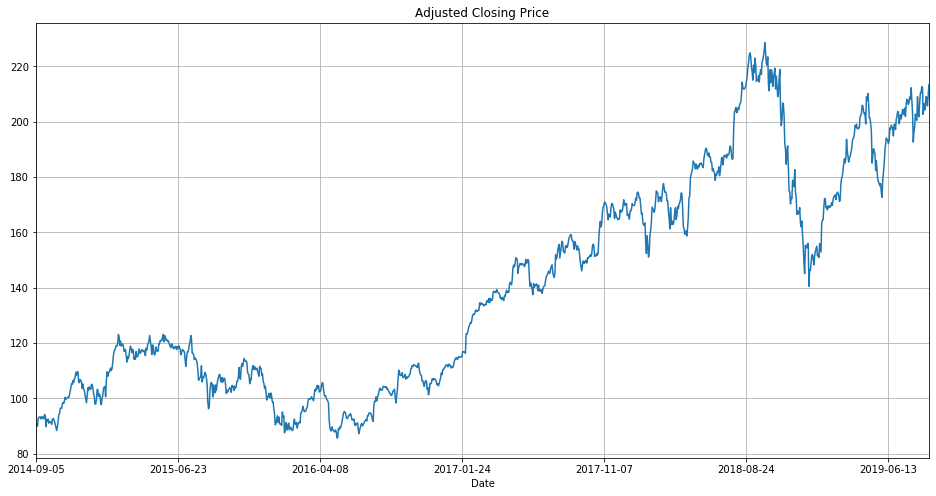

In [4]:
df['Adj Close'].plot(label='AAPL', figsize=(16,8), title='Adjusted Closing Price', grid=True)

To make this more robust to noise and to leverage past values, we will not use the date to predict the stock prices, but we will use batches of 32 prices where each training example, we leverage 32 prices from the past to predict the price on the 33rd day.  We will thus have $N - 32$ training examples with $N$ being the number of days we've downloaded for the stock data.  We will thus create a 2D matrix of training samples with each row being the prices 32 consecutive days in the past with the price to predict being the current day.

In [5]:
window_size = 32 # Allow us to look at 32 days into the past
# Prepare the data so that we have 32 day windows and predict what the next day should be

# Get indices of access for the data
num_samples = len(df) - window_size
# we need the [:,None] to make it a 219x1 matrix. Otherwise it would just be a vector of length 219
# the part after the '+' is an array from 0 to 32, indices is an array with 219 rows and 33 columns
indices = np.arange(num_samples).astype(np.int)[:,None] + np.arange(window_size + 1).astype(np.int)

Now we create a 2D matrix with 219 rows and 33 columns. The first 32 columns are our predictors and the 33rd column is the target we want to predict.

In [6]:
data = df['Adj Close'].values[indices] # Create the 2D matrix of training samples

Now split this data matrix up into predictors and target

In [7]:
X = data[:,:-1] # each row corresponds to 32 days in the past
Y = data[:,-1] # each entry corresponds to the 33rd day we want to predict

We are going to split our data into 80% training set and 20% test set. Note that we *do not* want to split randomly here. The order of observations correspodns to consecutive days, so it definitely matters.

In [8]:
# Train and test split
split_fraction = 0.8
ind_split = int(split_fraction * num_samples)
X_train = X[:ind_split]
Y_train = Y[:ind_split]
X_test = X[ind_split:]
Y_test = Y[ind_split:]

# Method 1 - Ridge Regression

As a first regression method we will use Ridge regression to predict Apple stock prices and plot the results to assess performance.

In [12]:
# Train
ridge_model = Ridge()
ridge_model.fit(X_train, Y_train)

# Let's see how well the model fits the training data and test data
Y_pred_train_ridge = ridge_model.predict(X_train)
Y_pred_ridge = ridge_model.predict(X_test)

Let's see, what the fitted coefficients actually look like.

In [13]:
ridge_model.coef_

array([ 0.07996134, -0.03755467, -0.01631886, -0.00802055,  0.02759244,
       -0.06551575,  0.07509252, -0.04256721,  0.02425614, -0.02186304,
       -0.0357001 ,  0.00781873, -0.01788777,  0.05133949, -0.07166364,
        0.06340089,  0.03150931, -0.06576805,  0.06793596, -0.00912846,
       -0.01745245, -0.02515704, -0.03343606,  0.1232959 , -0.12960438,
        0.06330097, -0.0044844 , -0.04243515,  0.05163079,  0.00900617,
       -0.10049354,  1.07165854])

Well, no real surprise there: The last coefficient, i.e. the coefficient corresponding to the previous day, is the largest. This is to be expected: The stock price on the previous day would be most indicative for the stockprice of the next day.

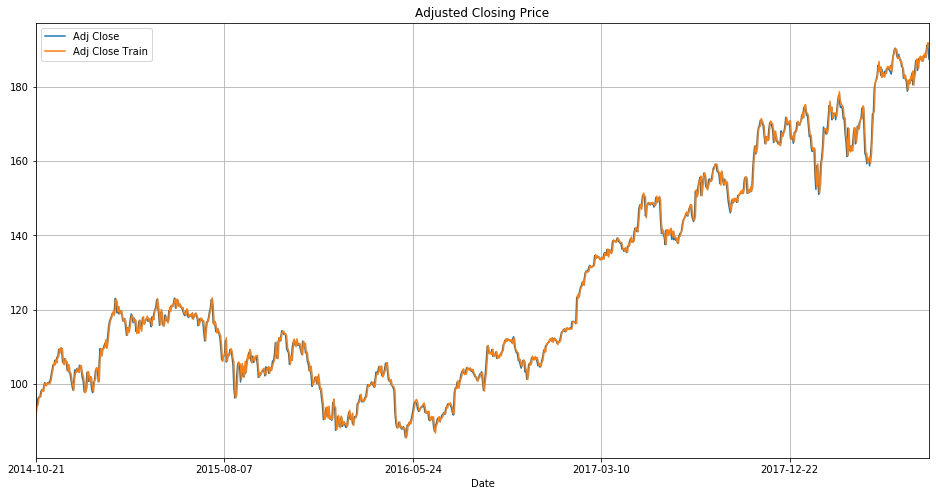

In [14]:
# Plot what it looks like for the training data
df_ridge = df.copy()
df_ridge.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_ridge = df_ridge.iloc[window_size:ind_split] # Past 32 days we don't know yet
df_ridge['Adj Close Train'] = Y_pred_train_ridge[:-window_size]
df_ridge.plot(label='AAPL', figsize=(16,8), title='Adjusted Closing Price', grid=True)

This fits the data very well. We might be overfitting slightly, though... let's find out by testing our model against the test data.

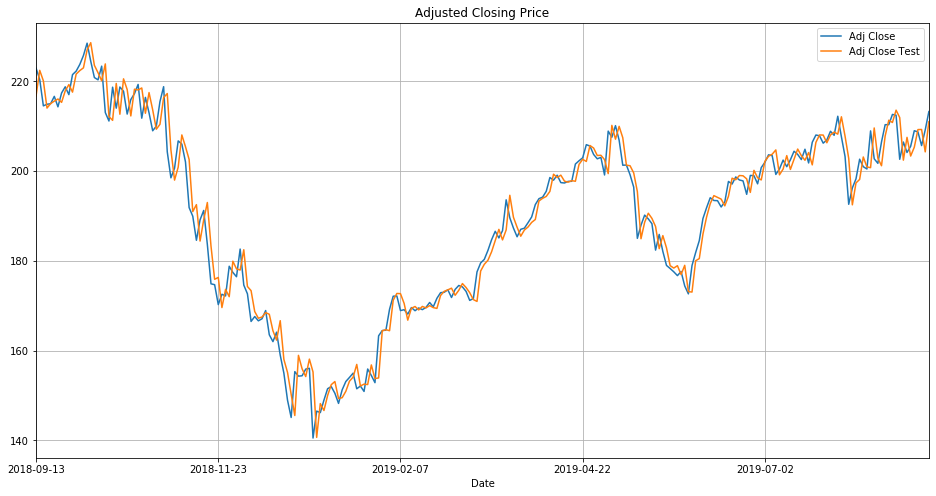

In [15]:
# Same for the test
df_ridge = df.copy()
df_ridge.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_ridge = df_ridge.iloc[ind_split+window_size:] # Past 32 days we don't know yet
df_ridge['Adj Close Test'] = Y_pred_ridge
df_ridge.plot(label='AAPL', figsize=(16,8), title='Adjusted Closing Price', grid=True)

Actually, the prediction is not too bad. We do observe one distinctive feature, though: The orange curve, i.e. our predictions, seem to be shifted to the right from the real data, i.e. they are trailing behind the real prices. This makes sense and is what we should expect from looking at the coefficients of the model: The stock price of the previous day has the biggest impact on the stock price we are predicting for the next day. Hence, it is to be expected that our predictions are always lagging behind the real curve, which is exactly the pattern we observe above.

# Method 2 - Gradient Boosting Trees

Let's perform the same steps as in Method 1, just for Gradient Boosting Trees from Scikit-learn.

In [16]:
# Model #2 - Gradient Boosting Trees
gb_model = GradientBoostingRegressor()
gb_model.fit(X_train, Y_train)

# Let's see how well we fit the training and test data
Y_pred_train_gb = gb_model.predict(X_train)
Y_pred_gb = gb_model.predict(X_test)

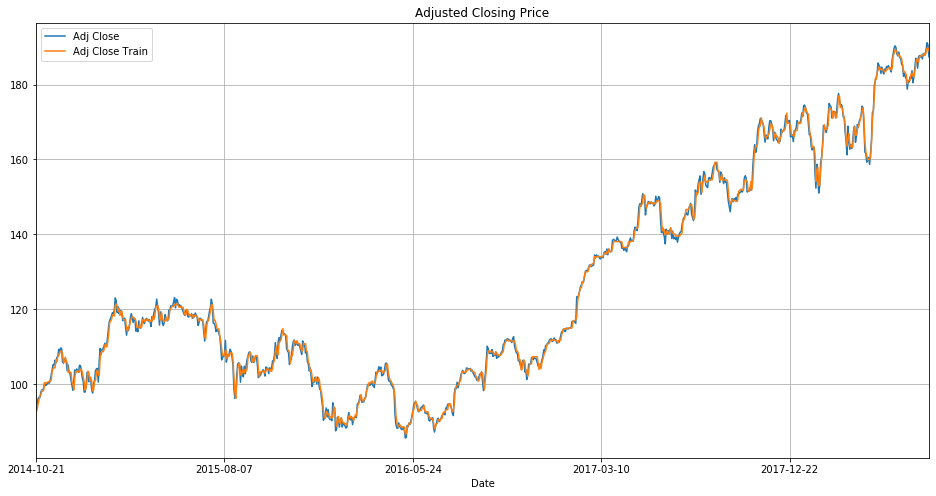

In [17]:
# Plot what it looks like for the training data
df_gb = df.copy()
df_gb.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_gb = df_gb.iloc[window_size:ind_split] # Past 32 days we don't know yet
df_gb['Adj Close Train'] = Y_pred_train_gb[:-window_size]
df_gb.plot(label='AAPL', figsize=(16,8), title='Adjusted Closing Price', grid=True)

The fitted data hugs the real curve very tightly. We do observe nicely (look at the regions with many small perturbations) that our predictions are a smooth fit through the data.

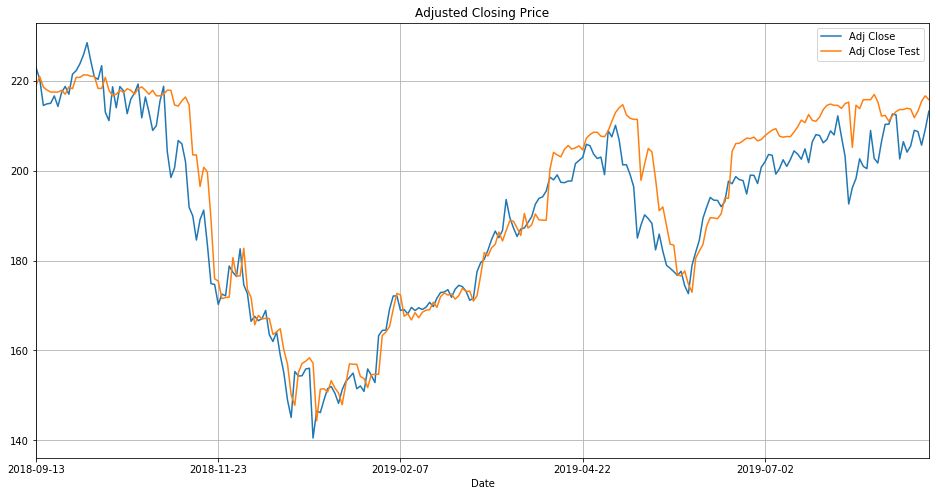

In [23]:
# Same for the test
df_gb = df.copy()
df_gb.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_gb = df_gb.iloc[ind_split+window_size:] # Past 32 days we don't know yet
df_gb['Adj Close Test'] = Y_pred_gb
df_gb.plot(label='APPL', figsize=(16,8), title='Adjusted Closing Price', grid=True)

Well... that didn't work too well. Boosting trees perform majority voting, so there is no interpolation involved in the predictions and thus, in areas of steep gradient, the model is performing poorly. 

# Method 3 - Using neural networks with 1D convolutional and LSTM layers

The last method we'll use is a neural network based one using Keras / Tensorflow.  We use a stack of Conv1D and LSTM layers, followed by Dense layers lastly followed by a linear layer to predict the stock price.

In [19]:
# Model #3 - Using RNNs
keras_model = Sequential([
  Conv1D(filters=128, kernel_size=5, input_shape=(window_size, 1), strides=1, padding="causal", activation="tanh"),
  Conv1D(filters=128, kernel_size=5, strides=1, padding="causal", activation="tanh"),
  LSTM(128, return_sequences=True),
  LSTM(128),
  Dense(64, activation="tanh"),
  Dense(64, activation="tanh"),
  Dense(1)
])

keras_model.summary()

W0906 21:48:20.080069 4390802880 deprecation_wrapper.py:119] From /anaconda3/envs/dl_pytorch/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0906 21:48:20.117327 4390802880 deprecation_wrapper.py:119] From /anaconda3/envs/dl_pytorch/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0906 21:48:20.119957 4390802880 deprecation_wrapper.py:119] From /anaconda3/envs/dl_pytorch/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 32, 128)           768       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 32, 128)           82048     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32, 128)           131584    
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total para

This is a technique to find the optimal learning rate for the neural network.  Specifically we gradually increase the learning rate at each epoch, recording the loss for each then choosing the learning rate that has the smallest loss overall.

Also, neural networks learn better when the data is normalized so we will normalize the data to the $[-1,1]$ range by using Scikit-learn's `MinMaxScaler`.  Therefore, we need to find apply this scaling on all of the price data, then decompose it into the training and test sets again.

In [20]:
# First figure out the right learning rate
lr_schedule = LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = SGD(lr=1e-8, momentum=0.9)
keras_model.compile(loss=Huber(),
                    optimizer=optimizer,
                    metrics=["mae"])
# Scale the data due to LSTM units
scaler = MinMaxScaler(feature_range=(-1, 1))
# This scales the data appropriately 
data_transform = scaler.fit_transform(df['Adj Close'].values[:,None])
# This splits the data into a 2D matrix again as before
data_transform = data_transform[indices]
X2 = data_transform[:,:-1]
Y2 = data_transform[:,-1]
X_train_reshape = X2[:ind_split]
Y_train_reshape = Y2[:ind_split]
X_test_reshape = X2[ind_split:]
Y_test_reshape = Y2[ind_split:]

W0906 21:48:24.387837 4390802880 deprecation_wrapper.py:119] From /anaconda3/envs/dl_pytorch/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [21]:
history = keras_model.fit(X_train_reshape, Y_train_reshape, batch_size=256, epochs=250, callbacks=[lr_schedule], validation_data=(X_test_reshape, Y_test_reshape))

W0906 21:48:26.774563 4390802880 deprecation.py:323] From /anaconda3/envs/dl_pytorch/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0906 21:48:27.894735 4390802880 deprecation_wrapper.py:119] From /anaconda3/envs/dl_pytorch/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0906 21:48:27.959427 4390802880 deprecation_wrapper.py:119] From /anaconda3/envs/dl_pytorch/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 981 samples, validate on 246 samples
Epoch 1/250
981/981 [==============================] - 7s 7ms/step - loss: 0.1425 - mean_absolute_error: 0.4699 - val_loss: 0.1193 - val_mean_absolute_error: 0.4282
Epoch 2/250
981/981 [==============================] - 3s 3ms/step - loss: 0.1425 - mean_absolute_error: 0.4699 - val_loss: 0.1193 - val_mean_absolute_error: 0.4282
Epoch 3/250
981/981 [==============================] - 2s 2ms/step - loss: 0.1425 - mean_absolute_error: 0.4699 - val_loss: 0.1193 - val_mean_absolute_error: 0.4282
Epoch 4/250
981/981 [==============================] - 2s 2ms/step - loss: 0.1425 - mean_absolute_error: 0.4699 - val_loss: 0.1193 - val_mean_absolute_error: 0.4282
Epoch 5/250
981/981 [==============================] - 2s 2ms/step - loss: 0.1425 - mean_absolute_error: 0.4699 - val_loss: 0.1193 - val_mean_absolute_error: 0.4282
Epoch 6/250
981/981 [==============================] - 2s 2ms/step - loss: 0.1425 - mean_absolute_error: 0.4699 - val_loss: 0.119

981/981 [==============================] - 2s 2ms/step - loss: 0.1413 - mean_absolute_error: 0.4680 - val_loss: 0.1198 - val_mean_absolute_error: 0.4291
Epoch 51/250
981/981 [==============================] - 2s 2ms/step - loss: 0.1411 - mean_absolute_error: 0.4678 - val_loss: 0.1198 - val_mean_absolute_error: 0.4292
Epoch 52/250
981/981 [==============================] - 2s 2ms/step - loss: 0.1410 - mean_absolute_error: 0.4675 - val_loss: 0.1199 - val_mean_absolute_error: 0.4293
Epoch 53/250
981/981 [==============================] - 2s 2ms/step - loss: 0.1408 - mean_absolute_error: 0.4672 - val_loss: 0.1200 - val_mean_absolute_error: 0.4295
Epoch 54/250
981/981 [==============================] - 2s 2ms/step - loss: 0.1406 - mean_absolute_error: 0.4669 - val_loss: 0.1201 - val_mean_absolute_error: 0.4296
Epoch 55/250
981/981 [==============================] - 2s 2ms/step - loss: 0.1404 - mean_absolute_error: 0.4665 - val_loss: 0.1201 - val_mean_absolute_error: 0.4298
Epoch 56/250
981/

981/981 [==============================] - 2s 2ms/step - loss: 0.0330 - mean_absolute_error: 0.2102 - val_loss: 0.1199 - val_mean_absolute_error: 0.4544
Epoch 100/250
981/981 [==============================] - 2s 2ms/step - loss: 0.0301 - mean_absolute_error: 0.1967 - val_loss: 0.1094 - val_mean_absolute_error: 0.4331
Epoch 101/250
981/981 [==============================] - 2s 2ms/step - loss: 0.0270 - mean_absolute_error: 0.1830 - val_loss: 0.0973 - val_mean_absolute_error: 0.4067
Epoch 102/250
981/981 [==============================] - 2s 2ms/step - loss: 0.0240 - mean_absolute_error: 0.1699 - val_loss: 0.0839 - val_mean_absolute_error: 0.3752
Epoch 103/250
981/981 [==============================] - 2s 2ms/step - loss: 0.0210 - mean_absolute_error: 0.1568 - val_loss: 0.0699 - val_mean_absolute_error: 0.3391
Epoch 104/250
981/981 [==============================] - 2s 2ms/step - loss: 0.0177 - mean_absolute_error: 0.1433 - val_loss: 0.0564 - val_mean_absolute_error: 0.3013
Epoch 105/25

981/981 [==============================] - 2s 2ms/step - loss: 0.0032 - mean_absolute_error: 0.0624 - val_loss: 0.0082 - val_mean_absolute_error: 0.1058
Epoch 149/250
981/981 [==============================] - 2s 2ms/step - loss: 0.0037 - mean_absolute_error: 0.0688 - val_loss: 0.0094 - val_mean_absolute_error: 0.1082
Epoch 150/250
981/981 [==============================] - 2s 2ms/step - loss: 0.0446 - mean_absolute_error: 0.2608 - val_loss: 0.0596 - val_mean_absolute_error: 0.3173
Epoch 151/250
981/981 [==============================] - 2s 2ms/step - loss: 0.0362 - mean_absolute_error: 0.2370 - val_loss: 0.0332 - val_mean_absolute_error: 0.2192
Epoch 152/250
981/981 [==============================] - 2s 2ms/step - loss: 0.0186 - mean_absolute_error: 0.1616 - val_loss: 0.0167 - val_mean_absolute_error: 0.1609
Epoch 153/250
981/981 [==============================] - 2s 2ms/step - loss: 0.0118 - mean_absolute_error: 0.1251 - val_loss: 0.0233 - val_mean_absolute_error: 0.1830
Epoch 154/25

Epoch 196/250
981/981 [==============================] - 2s 2ms/step - loss: 1928.0344 - mean_absolute_error: 1928.5342 - val_loss: 1468.5753 - val_mean_absolute_error: 1469.0742
Epoch 197/250
981/981 [==============================] - 2s 2ms/step - loss: 2163.1280 - mean_absolute_error: 2163.6282 - val_loss: 1652.3206 - val_mean_absolute_error: 1652.8208
Epoch 198/250
981/981 [==============================] - 2s 2ms/step - loss: 2426.9476 - mean_absolute_error: 2427.4472 - val_loss: 1858.4866 - val_mean_absolute_error: 1858.9873
Epoch 199/250
981/981 [==============================] - 2s 2ms/step - loss: 2722.9555 - mean_absolute_error: 2723.4562 - val_loss: 2089.8110 - val_mean_absolute_error: 2090.3103
Epoch 200/250
981/981 [==============================] - 2s 2ms/step - loss: 3055.0417 - mean_absolute_error: 3055.5419 - val_loss: 2349.3586 - val_mean_absolute_error: 2349.8582
Epoch 201/250
981/981 [==============================] - 2s 2ms/step - loss: 3427.6926 - mean_absolute_er

Epoch 241/250
981/981 [==============================] - 2s 2ms/step - loss: 342654.0696 - mean_absolute_error: 342654.6035 - val_loss: 267753.0312 - val_mean_absolute_error: 267753.7812
Epoch 242/250
981/981 [==============================] - 2s 2ms/step - loss: 384464.0825 - mean_absolute_error: 384464.4996 - val_loss: 300428.6875 - val_mean_absolute_error: 300429.0938
Epoch 243/250
981/981 [==============================] - 2s 2ms/step - loss: 431375.7898 - mean_absolute_error: 431376.0736 - val_loss: 337091.2188 - val_mean_absolute_error: 337091.3438
Epoch 244/250
981/981 [==============================] - 2s 2ms/step - loss: 484011.3292 - mean_absolute_error: 484011.7504 - val_loss: 378226.1875 - val_mean_absolute_error: 378227.1250
Epoch 245/250
981/981 [==============================] - 2s 2ms/step - loss: 543069.5609 - mean_absolute_error: 543069.9508 - val_loss: 424381.5000 - val_mean_absolute_error: 424381.7812
Epoch 246/250
981/981 [==============================] - 2s 2ms/s

Let's plot the loss for the testing data versus the learning rate.

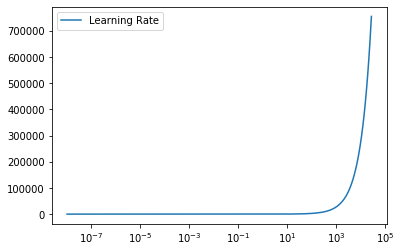

In [24]:
plt.semilogx(history.history['lr'], history.history['val_loss'])
plt.legend(['Learning Rate', 'Validation Loss'])

Well, unsurprisingly, if we choose a learning rate much larger than 10, our validation loss explodes. If the learning rate is too large, we will not converge and not get sensible predictions. Let us zoom in on the critical point a little more.

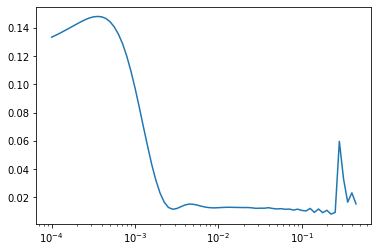

In [25]:
plt.semilogx(history.history['lr'][80:154], history.history['val_loss'][80:154])

Looks like a learning rate of 0.1 might be doing reasonably well. So let's use that and train the model for real this time.

In [26]:
# Observing the above graph, 0.1 seems to be a reasonable learning rate
keras_model = Sequential([
  Conv1D(filters=128, kernel_size=5, input_shape=(window_size, 1), strides=1, padding="causal", activation="tanh"),
  Conv1D(filters=128, kernel_size=5, strides=1, padding="causal", activation="tanh"),
  LSTM(128, return_sequences=True),
  LSTM(128),
  Dense(64, activation="tanh"),
  Dense(64, activation="tanh"),
  Dense(1)
])


optimizer = SGD(lr=0.1, momentum=0.9)
keras_model.compile(loss=Huber(),
                    optimizer=optimizer,
                    metrics=["mae"])
history = keras_model.fit(X_train_reshape, Y_train_reshape, batch_size=256, epochs=250, validation_data=(X_test_reshape, Y_test_reshape))

Train on 981 samples, validate on 246 samples
Epoch 1/250
981/981 [==============================] - 8s 8ms/step - loss: 0.1256 - mean_absolute_error: 0.4328 - val_loss: 0.0796 - val_mean_absolute_error: 0.3652
Epoch 2/250
981/981 [==============================] - 2s 2ms/step - loss: 0.0375 - mean_absolute_error: 0.2337 - val_loss: 0.0351 - val_mean_absolute_error: 0.2222
Epoch 3/250
981/981 [==============================] - 2s 2ms/step - loss: 0.0304 - mean_absolute_error: 0.2064 - val_loss: 0.0644 - val_mean_absolute_error: 0.3108
Epoch 4/250
981/981 [==============================] - 2s 2ms/step - loss: 0.0223 - mean_absolute_error: 0.1802 - val_loss: 0.0127 - val_mean_absolute_error: 0.1380
Epoch 5/250
981/981 [==============================] - 2s 2ms/step - loss: 0.0134 - mean_absolute_error: 0.1398 - val_loss: 0.0166 - val_mean_absolute_error: 0.1352
Epoch 6/250
981/981 [==============================] - 2s 2ms/step - loss: 0.0098 - mean_absolute_error: 0.1163 - val_loss: 0.023

981/981 [==============================] - 2s 2ms/step - loss: 0.0018 - mean_absolute_error: 0.0454 - val_loss: 0.0063 - val_mean_absolute_error: 0.0824
Epoch 51/250
981/981 [==============================] - 2s 2ms/step - loss: 0.0018 - mean_absolute_error: 0.0453 - val_loss: 0.0058 - val_mean_absolute_error: 0.0802
Epoch 52/250
981/981 [==============================] - 2s 2ms/step - loss: 0.0018 - mean_absolute_error: 0.0448 - val_loss: 0.0066 - val_mean_absolute_error: 0.0835
Epoch 53/250
981/981 [==============================] - 2s 2ms/step - loss: 0.0018 - mean_absolute_error: 0.0443 - val_loss: 0.0058 - val_mean_absolute_error: 0.0799
Epoch 54/250
981/981 [==============================] - 3s 3ms/step - loss: 0.0017 - mean_absolute_error: 0.0442 - val_loss: 0.0057 - val_mean_absolute_error: 0.0790
Epoch 55/250
981/981 [==============================] - 2s 2ms/step - loss: 0.0018 - mean_absolute_error: 0.0449 - val_loss: 0.0063 - val_mean_absolute_error: 0.0822
Epoch 56/250
981/

981/981 [==============================] - 2s 2ms/step - loss: 0.0014 - mean_absolute_error: 0.0402 - val_loss: 0.0042 - val_mean_absolute_error: 0.0690
Epoch 100/250
981/981 [==============================] - 2s 2ms/step - loss: 0.0015 - mean_absolute_error: 0.0408 - val_loss: 0.0050 - val_mean_absolute_error: 0.0749
Epoch 101/250
981/981 [==============================] - 2s 2ms/step - loss: 0.0014 - mean_absolute_error: 0.0401 - val_loss: 0.0043 - val_mean_absolute_error: 0.0697
Epoch 102/250
981/981 [==============================] - 2s 2ms/step - loss: 0.0014 - mean_absolute_error: 0.0394 - val_loss: 0.0044 - val_mean_absolute_error: 0.0698
Epoch 103/250
981/981 [==============================] - 2s 2ms/step - loss: 0.0014 - mean_absolute_error: 0.0397 - val_loss: 0.0044 - val_mean_absolute_error: 0.0700
Epoch 104/250
981/981 [==============================] - 2s 2ms/step - loss: 0.0014 - mean_absolute_error: 0.0393 - val_loss: 0.0045 - val_mean_absolute_error: 0.0712
Epoch 105/25

981/981 [==============================] - 2s 2ms/step - loss: 0.0011 - mean_absolute_error: 0.0348 - val_loss: 0.0034 - val_mean_absolute_error: 0.0636
Epoch 149/250
981/981 [==============================] - 2s 2ms/step - loss: 0.0011 - mean_absolute_error: 0.0347 - val_loss: 0.0039 - val_mean_absolute_error: 0.0660
Epoch 150/250
981/981 [==============================] - 2s 2ms/step - loss: 0.0011 - mean_absolute_error: 0.0348 - val_loss: 0.0034 - val_mean_absolute_error: 0.0631
Epoch 151/250
981/981 [==============================] - 2s 2ms/step - loss: 0.0011 - mean_absolute_error: 0.0349 - val_loss: 0.0038 - val_mean_absolute_error: 0.0657
Epoch 152/250
981/981 [==============================] - 2s 3ms/step - loss: 0.0011 - mean_absolute_error: 0.0349 - val_loss: 0.0034 - val_mean_absolute_error: 0.0632
Epoch 153/250
981/981 [==============================] - 2s 2ms/step - loss: 0.0011 - mean_absolute_error: 0.0346 - val_loss: 0.0037 - val_mean_absolute_error: 0.0647
Epoch 154/25

Epoch 197/250
981/981 [==============================] - 2s 2ms/step - loss: 9.6701e-04 - mean_absolute_error: 0.0319 - val_loss: 0.0034 - val_mean_absolute_error: 0.0616
Epoch 198/250
981/981 [==============================] - 2s 2ms/step - loss: 9.6790e-04 - mean_absolute_error: 0.0319 - val_loss: 0.0032 - val_mean_absolute_error: 0.0611
Epoch 199/250
981/981 [==============================] - 2s 2ms/step - loss: 9.4936e-04 - mean_absolute_error: 0.0318 - val_loss: 0.0033 - val_mean_absolute_error: 0.0611
Epoch 200/250
981/981 [==============================] - 3s 3ms/step - loss: 9.7637e-04 - mean_absolute_error: 0.0322 - val_loss: 0.0032 - val_mean_absolute_error: 0.0610
Epoch 201/250
981/981 [==============================] - 2s 2ms/step - loss: 9.3569e-04 - mean_absolute_error: 0.0315 - val_loss: 0.0032 - val_mean_absolute_error: 0.0609
Epoch 202/250
981/981 [==============================] - 2s 2ms/step - loss: 9.3703e-04 - mean_absolute_error: 0.0317 - val_loss: 0.0032 - val_me

Epoch 245/250
981/981 [==============================] - 2s 2ms/step - loss: 9.0581e-04 - mean_absolute_error: 0.0312 - val_loss: 0.0032 - val_mean_absolute_error: 0.0607
Epoch 246/250
981/981 [==============================] - 2s 2ms/step - loss: 9.1262e-04 - mean_absolute_error: 0.0315 - val_loss: 0.0031 - val_mean_absolute_error: 0.0605
Epoch 247/250
981/981 [==============================] - 2s 2ms/step - loss: 8.9988e-04 - mean_absolute_error: 0.0313 - val_loss: 0.0033 - val_mean_absolute_error: 0.0609
Epoch 248/250
981/981 [==============================] - 2s 2ms/step - loss: 8.7984e-04 - mean_absolute_error: 0.0308 - val_loss: 0.0030 - val_mean_absolute_error: 0.0598
Epoch 249/250
981/981 [==============================] - 2s 2ms/step - loss: 8.6614e-04 - mean_absolute_error: 0.0303 - val_loss: 0.0033 - val_mean_absolute_error: 0.0606
Epoch 250/250
981/981 [==============================] - 2s 2ms/step - loss: 8.5345e-04 - mean_absolute_error: 0.0300 - val_loss: 0.0032 - val_me

Once we predict the values, we also must *reverse* the normalization so that we can plot the predictions in the same scale as the original values.

In [27]:
Y_pred_train_keras = scaler.inverse_transform(keras_model.predict(X_train_reshape, batch_size=256))
Y_pred_keras = scaler.inverse_transform(keras_model.predict(X_test_reshape, batch_size=256))

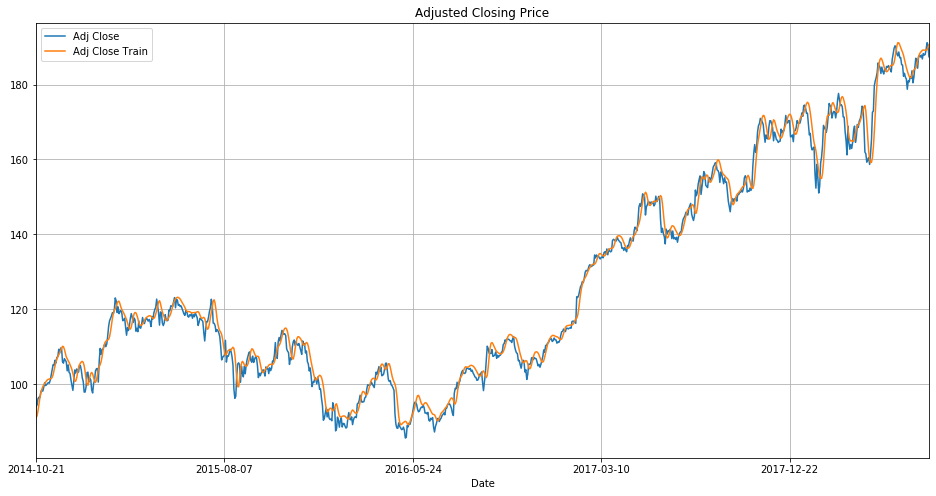

In [28]:
# Plot what it looks like for the training data
df_keras = df.copy()
df_keras.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_keras = df_keras.iloc[window_size:ind_split] # Past 32 days we don't know yet
df_keras['Adj Close Train'] = Y_pred_train_keras[:-window_size]
df_keras.plot(label='AAPL', figsize=(16,8), title='Adjusted Closing Price', grid=True)

Hugs the data closeley.

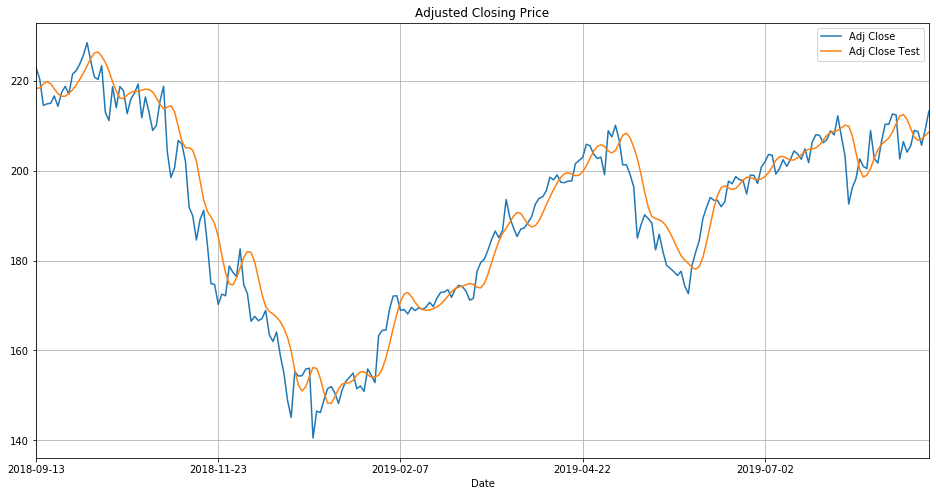

In [29]:
# Same for the test
df_keras = df.copy()
df_keras.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_keras = df_keras.iloc[ind_split+window_size:] # Past 32 days we don't know yet
df_keras['Adj Close Test'] = Y_pred_keras
df_keras.plot(label='AAPL', figsize=(16,8), title='Adjusted Closing Price', grid=True)

Well... not so great, really... the model seems to be oversmoothing.

Finally to see how everything performs, let's plot all of the methods together for both the training and testing data.

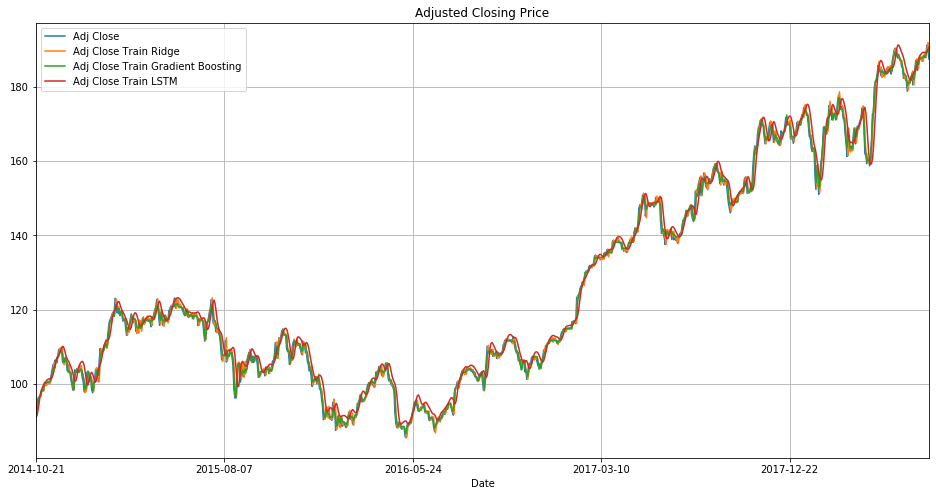

In [30]:
df_train = df.copy()
df_train.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_train = df_train.iloc[window_size:ind_split] # Past 32 days we don't know yet
# Add in all of our methods
df_train['Adj Close Train Ridge'] = Y_pred_train_ridge[:-window_size]
df_train['Adj Close Train Gradient Boosting'] = Y_pred_train_gb[:-window_size]
df_train['Adj Close Train LSTM'] = Y_pred_train_keras[:-window_size]
# Plot the data now
df_train.plot(label='AAPL', figsize=(16,8), title='Adjusted Closing Price', grid=True)

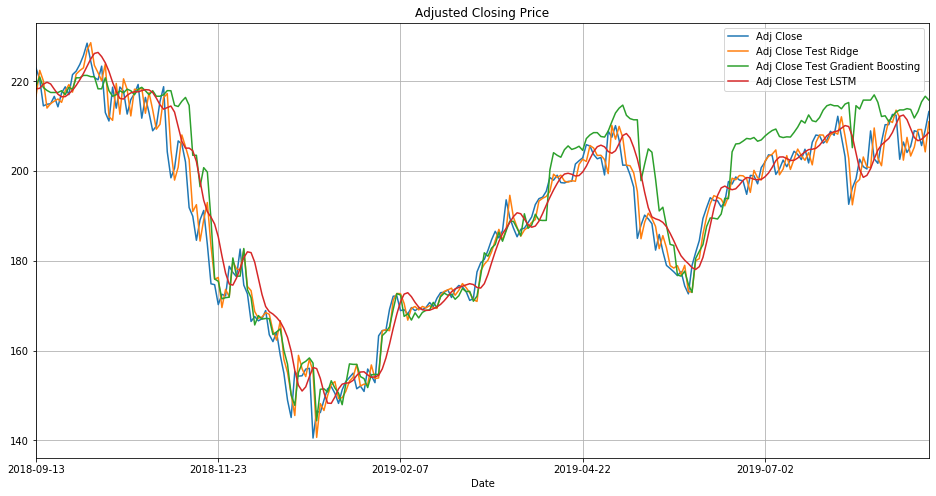

In [31]:
df_test = df.copy()
df_test.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_test = df_test.iloc[ind_split+window_size:] # Past 32 days we don't know yet
# Add in all of our methods
df_test['Adj Close Test Ridge'] = Y_pred_ridge
df_test['Adj Close Test Gradient Boosting'] = Y_pred_gb
df_test['Adj Close Test LSTM'] = Y_pred_keras
# Plot the data now
df_test.plot(label='AAPL', figsize=(16,8), title='Adjusted Closing Price', grid=True)


So here's where it gets interesting.  We can see that the neural network based method is what the values would be when there's no presence of noise.  The ridge regression based method seems to follow the trend the best with the noise modelled in.  The gradient boosting method also follows the same trend, but because the method does not use interpolation, points of very high curvature tend to be the most inaccurate.